In [1]:
import os
import yaml
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt

LABELS_PATH="labels.yaml"

2023-01-17 03:46:18.460362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 03:46:19.152518: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-11.3/targets/x86_64-linux/lib
2023-01-17 03:46:19.152648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidi

In [2]:
model = tf.keras.models.load_model('output')
model.summary()

2023-01-17 03:46:20.190566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-17 03:46:20.220463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-17 03:46:20.220637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-17 03:46:20.220964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 4)         40        
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 4)         148       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 4)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 4)         0         
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               204928    
                                                        

In [3]:
with open(LABELS_PATH) as f:
    label_map = yaml.load(f, Loader=yaml.SafeLoader)["labels"]
reverse_label_map = {v:k for k,v in label_map.items()}
repr(reverse_label_map)

image_files = []
IMAGES_DIR="images/good"
for dir,_,files in os.walk(IMAGES_DIR):
    for file in files:
        image_files.append(os.path.join(dir, file))
print(len(image_files))
print(image_files[0])

761
images/good/locomotor/74799e12-1403-4409-9744-dec87227716f.png


In [4]:
def predict(image):
    img_array = np.asarray(image, dtype=np.uint8).reshape(40,40, 1)
    formatted_img_array = np.expand_dims(img_array, axis=0)

    output_data = model.predict(formatted_img_array)
    raw_pred_prob = np.max(output_data)
    raw_pred = tf.argmax(output_data, 1).numpy()[0]

    return (raw_pred, raw_pred_prob)

images/good/descendo/82bc6f31-bf7d-467b-9213-852154a37f73.png
1/1 [==============================] - 0s 15ms/step
descendo - 1.0
live: descendo - local: descendo (KEEP)


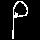

In [41]:
random_path = random.sample(image_files, k=1)[0]
live_label = random_path.split(os.path.sep)[2]
print(random_path)
i = Image.open(random_path).point(lambda x: 255 if x>0 else 0)
pred = predict(i)
print(f"{reverse_label_map[pred[0]]} - {pred[1]}")
if pred[1] < .95:
    status = "DISCARD"
else:
    status = "KEEP"
print(f"live: {live_label} - local: {reverse_label_map[pred[0]]} ({status})")
display(i)